In [1]:
import pandas as pd
import tkinter as tk
from tkinter import filedialog
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Necessary utility modules and libraries
import os
import shutil
import pathlib
import random
import datetime
import cv2


# Plotting libraries 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.signal import gaussian, convolve2d
import seaborn as sns



# Libraries for building the model
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, MaxPool2D, Dropout, Activation, GlobalAveragePooling2D, BatchNormalization, GlobalMaxPooling2D
from tensorflow.keras.applications import DenseNet121, ResNet50, InceptionV3, Xception, VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend
from tensorflow.keras.regularizers import l2, l1
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score, confusion_matrix

from PIL import Image
from tkinter import Tk, filedialog

print('Libraries are loaded')

Libraries are loaded


In [2]:
# Loading N Images from the selected path

def fetch_images_from_path(path, num_images):
    images = []
    count = 0

    for filename in os.listdir(path):
        if count >= num_images:
            break

        image_path = os.path.join(path, filename)
        if os.path.isfile(image_path):
            image = np.array(Image.open(image_path).resize((1024, 1024)))
            images.append(image)
            count += 1

    images = np.array(images)

    return images

# Prompt the user to select a directory using a file dialog
Tk().withdraw()  # Hide the Tkinter root window
directory = filedialog.askdirectory(title='Select the directory where the images are located')

# Ensure a directory was selected
if directory:
    num_images = 500 # Set the desired number of images
    selected_images = fetch_images_from_path(directory, num_images)

    # Print the shape of selected images array
    print(selected_images.shape)
else:
    print("No directory selected.")


2023-06-28 12:36:34.588 python[28971:8751442] +[CATransaction synchronize] called within transaction


(500, 1024, 1024, 3)


In [3]:
# Load the labels CSV file (Only first N records are selected)

Labels_Data = pd.read_csv(filedialog.askopenfilename(), header=0)
Labels_Data = Labels_Data.head(500)

print('Labels file is loaded')

2023-06-28 12:39:28.683 python[28971:8751442] +[CATransaction synchronize] called within transaction
2023-06-28 12:39:28.756 python[28971:8751442] +[CATransaction synchronize] called within transaction
2023-06-28 12:39:31.457 python[28971:8751442] +[CATransaction synchronize] called within transaction


Labels file is loaded


In [4]:
Labels_Data.shape

(15, 2)

In [4]:
# Convert the list of images to a numpy array
X = np.array(selected_images)

# Extract the labels
y = Labels_Data['level'].values

print('This step to create Arrays is completed')

This step to create Arrays is completed


In [5]:
# Delete unwanted variables
del selected_images

In [6]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

In [7]:
# Delete unwanted variables
del X

In [8]:
# Flatten the image data
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Normalize the features
X_train = X_train / 255.0
X_test = X_test / 255.0

In [10]:
# Train the model without Hyper Parameter Tunning

# Reshape the input data
X_train_reshaped = np.reshape(X_train, (-1, 1024, 1024, 3))
X_test_reshaped = np.reshape(X_test, (-1, 1024, 1024, 3))

# Build the ANN model
model = keras.Sequential([
    keras.layers.Dense(8, activation='relu', input_shape=(1024, 1024, 3)),
    keras.layers.Flatten(),
    keras.layers.Dense(2, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_reshaped, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


Epoch 1/10
13/13 [==============================] - 150s 11s/step - loss: 13.8753 - accuracy: 0.1725
Epoch 2/10
13/13 [==============================] - 170s 13s/step - loss: -53.9896 - accuracy: 0.0650
Epoch 3/10
13/13 [==============================] - 162s 12s/step - loss: -118.9670 - accuracy: 0.0650
Epoch 4/10
13/13 [==============================] - 144s 11s/step - loss: -185.7822 - accuracy: 0.0650
Epoch 5/10
13/13 [==============================] - 131s 10s/step - loss: -276.5431 - accuracy: 0.0625
Epoch 6/10
13/13 [==============================] - 133s 10s/step - loss: -413.0268 - accuracy: 0.0650
Epoch 7/10
13/13 [==============================] - 150s 12s/step - loss: -682.9765 - accuracy: 0.0650
Epoch 8/10
13/13 [==============================] - 516s 42s/step - loss: -1066.4291 - accuracy: 0.0650
Epoch 9/10
13/13 [==============================] - 159s 12s/step - loss: -1710.0389 - accuracy: 0.4250
Epoch 10/10
4/4 [==============================] - 8s 1s/step - loss: 1383

In [12]:
# Train the model with Hyper Parameter Tunning

# Reshape the input data
X_train_reshaped = np.reshape(X_train, (-1, 1024, 1024, 3))
X_test_reshaped = np.reshape(X_test, (-1, 1024, 1024, 3))

# Split the data into training and validation sets
#X_train, X_val, y_train, y_val = train_test_split(X_train_reshaped, y_train, test_size=0.2, random_state=42)

# Define hyperparameters to tune
epochs_list = [5, 10, 15]  # Different values for the number of epochs
batch_sizes = [16, 32, 64]  # Different values for batch size
dense_units = [4, 8, 12]  # Different values for units in dense layers

results = []  # Store results for each combination of hyperparameters

# Perform hyperparameter tuning
for epochs in epochs_list:
    for batch_size in batch_sizes:
        for units in dense_units:
            # Build the ANN model
            model = keras.Sequential([
                keras.layers.Dense(units, activation='relu', input_shape=(1024, 1024, 3)),
                keras.layers.Flatten(),
                keras.layers.Dense(2, activation='relu'),
                keras.layers.Dense(1, activation='sigmoid')
            ])

            # Compile the model
            model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

            # Train the model
            history = model.fit(X_train_reshaped, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_reshaped, y_test), verbose=0)
            accuracy = history.history['val_accuracy'][-1]  # Get the final validation accuracy

            # Store the hyperparameters and the corresponding accuracy
            results.append({'epochs': epochs, 'batch_size': batch_size, 'units': units, 'accuracy': accuracy})

# Find the best hyperparameters and accuracy
best_result = max(results, key=lambda x: x['accuracy'])
best_epochs = best_result['epochs']
best_batch_size = best_result['batch_size']
best_units = best_result['units']
best_accuracy = best_result['accuracy']

# Print the best hyperparameters and accuracy
print("Best Hyperparameters:")
print(f"Epochs: {best_epochs}")
print(f"Batch Size: {best_batch_size}")
print(f"Units: {best_units}")
print(f"Accuracy: {best_accuracy}")

# Train the model with the best hyperparameters
best_model = keras.Sequential([
    keras.layers.Dense(best_units, activation='relu', input_shape=(1024, 1024, 3)),
    keras.layers.Flatten(),
    keras.layers.Dense(2, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

best_model.fit(X_train_reshaped, y_train, epochs=best_epochs, batch_size=best_batch_size, validation_data=(X_test_reshaped, y_test), verbose=0)

# Perform predictions on the test set
y_pred = best_model.predict(X_test_reshaped)
y_pred = np.round(y_pred).flatten()


Best Hyperparameters:
Epochs: 5
Batch Size: 64
Units: 4
Accuracy: 0.6666666865348816
1/1 [==============================] - 0s 104ms/step


In [22]:
# Print epoch value and accuracy
print("Epoch Value -> Accuracy:")
for result in results:
    if result['batch_size'] == best_batch_size and result['units'] == best_units:
        epoch_value = result['epochs']
        accuracy = result['accuracy']
        print(f"{epoch_value} -> {accuracy:.4f}")


Epoch Value -> Accuracy:
5 -> 0.6667
10 -> 0.3333
15 -> 0.3333


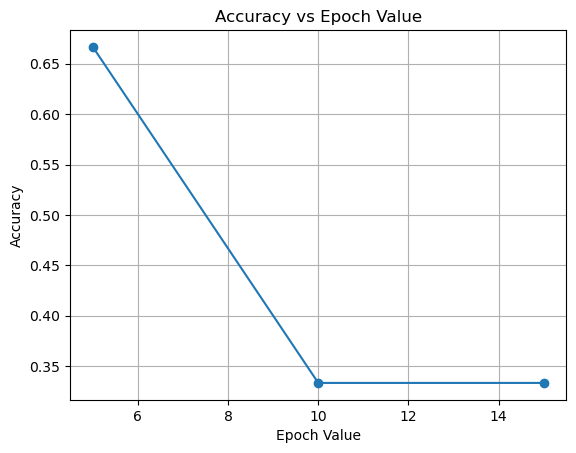

In [23]:
# Extract the accuracy values for the best batch size and units combination
epoch_values = [result['epochs'] for result in results if result['batch_size'] == best_batch_size and result['units'] == best_units]
accuracies = [result['accuracy'] for result in results if result['batch_size'] == best_batch_size and result['units'] == best_units]

# Plot epoch value vs accuracy
plt.plot(epoch_values, accuracies, 'o-')
plt.xlabel('Epoch Value')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch Value')
plt.grid(True)
plt.show()


In [16]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get the unique labels from y_test and D_pred
labels = sorted(set(y_test).union(set(y_pred)))

# Create a DataFrame for the confusion matrix
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

# Print the confusion matrix in a table format
print("Confusion Matrix:")
print(df_cm.to_string())

Confusion Matrix:
   0  1
0  0  2
1  0  1


In [ ]:
# Define the mapping dictionary
label_mapping = {
    0: "No Diabetic Retinopathy",
    1: "Early Stage",
    2: "Intermediate Stage",
    3: "Severe Retinopathy",
    4: "Progressive Retinopathy"
}

# Replace the values in the column with their corresponding labels
Labels_Data['level'] = Labels_Data['level'].map(label_mapping)

In [14]:


# 1) Print Prediction Results vs Test Labels
print("Prediction Results vs Test Labels:")
for pred, true_label in zip(y_pred, y_test):
    if pred != true_label:
        print(f"\033[91mPredicted: {pred}, True Label: {true_label} <-- Mismatch\033[0m")
    else:
        print(f"Predicted: {pred}, True Label: {true_label}")


Prediction Results vs Test Labels:
Predicted: 1.0, True Label: 0 <-- Mismatch
Predicted: 1.0, True Label: 1
Predicted: 1.0, True Label: 0 <-- Mismatch
